In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import DBSCAN
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

C:\Users\diksh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\diksh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\diksh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\diksh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
# Load processed data for star 
data_star1 = pd.read_csv('data_star1.csv')

# Select relevant features (assumes these have already been added to data_star1)
features = data_star1[['flux_diff', 'flux_ratio', 'flux_roll_mean', 'flux_roll_std']]

# Apply DBSCAN with fixed parameters
dbscan = DBSCAN(eps=4, min_samples=50)
clusters = dbscan.fit_predict(features)

# Store cluster labels
data_star1['cluster'] = clusters

# Define flux threshold (top 5%) as before 
flux_thresh = data_star1['pdcsap_flux'].quantile(0.95)

# Define flare points: outliers with high flux
data_star1['is_flare'] = ((data_star1['cluster'] == -1) & (data_star1['pdcsap_flux'] > flux_thresh)).astype(int)

### Fitting XGBoost Model

[0]	train-logloss:0.59879	test-logloss:0.59978
[1]	train-logloss:0.52161	test-logloss:0.52315
[2]	train-logloss:0.45713	test-logloss:0.45936
[3]	train-logloss:0.40261	test-logloss:0.40553
[4]	train-logloss:0.35604	test-logloss:0.35947
[5]	train-logloss:0.31602	test-logloss:0.32033
[6]	train-logloss:0.28117	test-logloss:0.28648
[7]	train-logloss:0.25087	test-logloss:0.25663
[8]	train-logloss:0.22431	test-logloss:0.23096
[9]	train-logloss:0.20092	test-logloss:0.20762
[10]	train-logloss:0.18019	test-logloss:0.18704
[11]	train-logloss:0.16185	test-logloss:0.16923
[12]	train-logloss:0.14559	test-logloss:0.15352
[13]	train-logloss:0.13114	test-logloss:0.13937
[14]	train-logloss:0.11817	test-logloss:0.12633
[15]	train-logloss:0.10655	test-logloss:0.11488
[16]	train-logloss:0.09621	test-logloss:0.10485
[17]	train-logloss:0.08699	test-logloss:0.09600
[18]	train-logloss:0.07870	test-logloss:0.08789
[19]	train-logloss:0.07120	test-logloss:0.08049
[20]	train-logloss:0.06445	test-logloss:0.07369
[2

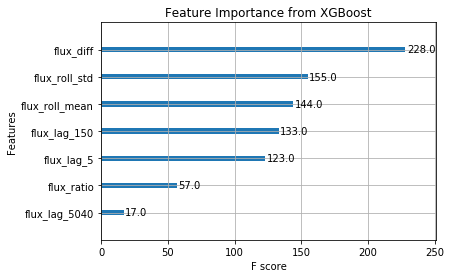

In [3]:
# create time lagged features 
data_star1['flux_lag_5'] = data_star1['pdcsap_flux'].shift(5)
data_star1['flux_lag_150'] = data_star1['pdcsap_flux'].shift(150)
data_star1['flux_lag_5040'] = data_star1['pdcsap_flux'].shift(5040)

# Split into train and test sets (first 80% train, last 20% test)
split_index = int(0.8 * len(data_star1))
train_data = data_star1.iloc[:split_index]
test_data = data_star1.iloc[split_index:]

# Separate features and target
X_train = train_data[['flux_diff', 'flux_ratio', 'flux_roll_mean', 'flux_roll_std', 'flux_lag_5', 'flux_lag_150','flux_lag_5040']]
y_train = train_data['is_flare']
X_test = test_data[['flux_diff', 'flux_ratio', 'flux_roll_mean', 'flux_roll_std', 'flux_lag_5', 'flux_lag_150','flux_lag_5040']]
y_test = test_data['is_flare']

# Convert to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    'objective': 'binary:logistic', 
    'eval_metric': 'logloss',
    'max_depth': 5, 
    'eta': 0.1, 
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Train the model
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=10,
    verbose_eval=True
)

# Predict
y_pred_proba = xgb_model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Flare', 'Flare']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot feature importance
xgb.plot_importance(xgb_model)
plt.title('Feature Importance from XGBoost')
plt.show()

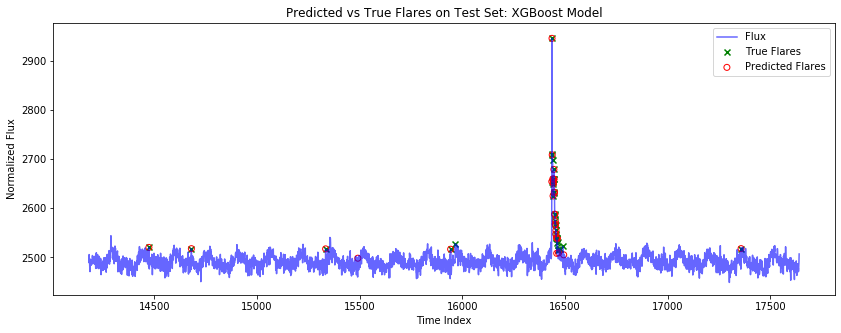

In [4]:
## visualize results! 

# Add predictions back to the test DataFrame
test_data = test_data.copy() 
test_data['predicted_flare'] = y_pred
test_data['predicted_proba'] = y_pred_proba

# Plot the flux time series
plt.figure(figsize=(14, 5))
plt.plot(test_data['index'], test_data['pdcsap_flux'], label='Flux', color='blue', alpha=0.6)

# Mark true flares
plt.scatter(
    test_data[test_data['is_flare'] == 1]['index'],
    test_data[test_data['is_flare'] == 1]['pdcsap_flux'],
    color='green', label='True Flares', marker='x'
)

# Mark predicted flares
plt.scatter(
    test_data[test_data['predicted_flare'] == 1]['index'],
    test_data[test_data['predicted_flare'] == 1]['pdcsap_flux'],
    color='red', label='Predicted Flares', marker='o', facecolors='none'
)

plt.legend()
plt.title("Predicted vs True Flares on Test Set: XGBoost Model")
plt.xlabel("Time Index")
plt.ylabel("Normalized Flux")
plt.savefig("xgboost-viz-plot", dpi=300)
plt.show()


### Fitting an LSTM for comparison

Used the minimum flux value from DBSCAN-detected flares as a threshold for flare labeling

In [5]:
# Identify flare points detected by DBSCAN
flare_points = data_star1[data_star1['is_flare'] == 1]  # '1' means detected as a flare

# Find the minimum flux value among detected flares
min_flare_flux = flare_points['pdcsap_flux'].min()

# Normalize the flux data
scaler = MinMaxScaler()
data_star1['pdcsap_flux'] = scaler.fit_transform(data_star1[['pdcsap_flux']])

# Train-test split (first 80% train, last 20% test)
train_size = int(len(data_star1) * 0.8)  
train_data, test_data = data_star1['pdcsap_flux'][:train_size].values, data_star1['pdcsap_flux'][train_size:].values

# Function to create sequences
def create_sequences(data, seq_length=100):
    
    """
    Creates input-output sequences for LSTM.
    
    Parameters:
    ----------
    data : array-like, 1D time series data  
    seq_length : int, number of time steps in each input sequence (default = 100 chosen based on rolling window)
    
    Returns:
    -------
    X : np.ndarray, shape (n_samples, seq_length), input sequences  
    y : np.ndarray, shape (n_samples,), target flux values following each sequence
    """
    
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 100
X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM Model 
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1),dropout=0.2, recurrent_dropout=0.2),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Add Early Stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with Early Stopping
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 13742 samples, validate on 3361 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
13742/13742 [==============================] - 75s 5ms/sample - loss: 5.5227e-04 - val_loss: 7.1865e-04
Epoch 2/20
13742/13742 [==============================] - 73s 5ms/sample - loss: 4.2963e-04 - val_loss: 6.1603e-04
Epoch 3/20
13742/13742 [==============================] - 73s 5ms/sample - loss: 3.8776e-04 - val_loss: 5.7967e-04
Epoch 4/20
13742/13742 [==============================] - 72s 5ms/sample - loss: 3.8945e-04 - val_loss: 5.1660e-04
Epoch 5/20
13742/13742 [==============================] - 73s 5ms/sample - loss: 4.0086e-04 - val_loss: 6.4839e-04
Epoch 6/20
13742/13742 [==============================] - 74s 5ms/sample - loss: 3.8700e-04 - val_loss: 6.2111e-04
Epoch 7/20
13742/13742 [=========================

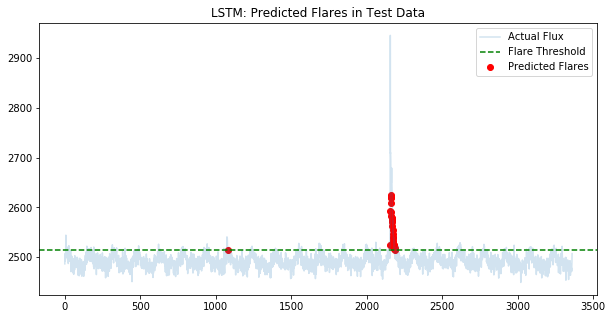

In [6]:
# Predict on test set 
y_pred = model.predict(X_test)

# Inverse transform predictions
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# visualize results 

# Classify Flares: If LSTM predicted flux > min_flare_flux, mark as a flare
flare_predictions = (y_pred > min_flare_flux).astype(int)
flare_indices = np.where(flare_predictions == 1)[0]

# Plot results
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual Flux', alpha=0.2)
#plt.plot(y_pred, label='Predicted Flux', linestyle='dashed', alpha=0.7)
plt.axhline(y=min_flare_flux, color='g', linestyle='--', label="Flare Threshold")
plt.scatter(flare_indices, y_pred[flare_indices], color='red', label="Predicted Flares")
plt.legend()
plt.title("Predicted vs True Flares on Test Set: LSTM Model")
plt.savefig("LSTM-final-plot", dpi=300)
plt.show()